<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>

Figure 1.1.a. Jupyter environment + Python notebooks

# Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

## Step 1.1: Configure the environment

In [5]:
from datetime import datetime
from shapely.geometry import Polygon
from shapely import box
from pyproj import CRS 
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
import rioxarray
import joblib
from ipyleaflet import basemaps
from numpy.lib.stride_tricks import sliding_window_view
import pystac_client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import planetary_computer
from odc.stac import load
from pystac.client import Client
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from matplotlib import colors
from utils import load_data, scale, calculate_band_indices, apply_mask, mask_land, mask_deeps, mask_elevation, all_masks, glcm_features, do_prediction, probability, output

In [6]:
# Reload scripts and imports
%load_ext autoreload
%autoreload 2

In [7]:
# Predefined variable for title and version

# Enter your initials
initials = "nm"

# Enter your site name
site = "bootless"

# Date
date = datetime.now()

# Make a clean version string
version = f"{initials}-{site}-{date.strftime('%d%m%Y')}"
print(version)

nm-bootless-22072025


## Step 1.2: Configure STAC access and search parameters

In [8]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [9]:
# ## Use training data bounds

training = gpd.read_file("training-data/nm-bootless-bay-13072025_postcard.geojson")
training = training.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = training.total_bounds

bbox = [min_lon, min_lat, max_lon, max_lat]

In [10]:
datetime = "2024"

items = client.search(
    collections=["dep_s2_geomad"],
    datetime=datetime,
    bbox=bbox
).item_collection()

print(f"Found {len(items)} items in for {datetime}")

Found 1 items in for 2024


In [11]:
measurements = ["nir", "red", "blue", "green", "emad", "smad", "bcmad", "green", "nir08", "nir09", "swir16", "swir22", "coastal", "rededge1", "rededge2", "rededge3"]
data = load_data(
    items,
    measurements,
    bbox,
)
    
# Now you can use the 'data' variable
print(data)

<xarray.Dataset> Size: 5MB
Dimensions:      (y: 490, x: 262, time: 1)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/15)
    nir          (time, y, x) uint16 257kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    red          (time, y, x) uint16 257kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    blue         (time, y, x) uint16 257kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    green        (time, y, x) uint16 257kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    emad         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    smad         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 257kB dask.arr

In [12]:
dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
configure_s3_access(cloud_defaults=True, requester_pays=True)

In [13]:
scaled = scale(data)
scaled = scaled.compute().squeeze()

In [14]:
scaled = calculate_band_indices(scaled)
Dataset = scaled

### GLCM texture analysis

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [15]:
WINDOW_SIZE = 9
LEVELS = 32

# Input
max = scaled.blue.max().values
min = scaled.blue.min().values
# Scale to 0-LEVELS for GLCM
img = ((scaled.blue - min) / (max - min) * (LEVELS - 1)).clip(0, LEVELS - 1).values.astype(np.uint8)

# Extract overlapping windows
patches = sliding_window_view(img, (WINDOW_SIZE, WINDOW_SIZE))
# Shape: (rows, cols, win_y, win_x)


In [16]:
import numpy as np # Ensure numpy is imported if not already

# Assuming 'patches' is a 4D NumPy array with dimensions (y_coords, x_coords, window_y_size, window_x_size)
# To get the first patch (at y=0, x=0), you would index it like this:
sample_patch_data = patches[0, 0, :, :]

# Verify the shape of the extracted sample patch data
print(f"Shape of sample_patch_data: {sample_patch_data.shape}")

# Call glcm_features directly on this 2D sample data
sample_result = glcm_features(sample_patch_data)

# Print the shape of the result to get the number of features
print(f"Shape of glcm_features output for a single patch: {sample_result.shape}")

Shape of sample_patch_data: (9, 9)
Shape of glcm_features output for a single patch: (7,)


In [17]:
# Use apply_ufunc to vectorize over (row, col) dimensions
result = xr.apply_ufunc(
    glcm_features,
    xr.DataArray(patches, dims=["y", "x", "win_y", "win_x"]),
    input_core_dims=[["win_y", "win_x"]],
    output_core_dims=[["feature"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.float32]
)

# Add coordinates & names
pad = WINDOW_SIZE - 1
result = result.assign_coords({
    "y": scaled.y[: -pad],
    "x": scaled.x[: -pad],
    "feature": ["contrast", "homogeneity", "energy", "ASM", "correlation", "mean", "entropy"]
})

result_bands = result.to_dataset(dim="feature")

# Combine with original
combined_ds = scaled.copy()
combined_ds = combined_ds.assign(result_bands)

combined_ds
combined_ds.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [18]:
# All masks
masked_scaled, mask = all_masks(combined_ds, return_mask = True)
masked_scaled.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

/srv/conda/envs/notebook/lib/python3.10/site-packages/odc/geo/_rgba.py:55: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")


In [19]:
masked_scaled

<xarray.Dataset> Size: 30MB
Dimensions:      (y: 490, x: 262)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir          (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    blue         (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    green        (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    emad         (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    smad         (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    ...           ...
    homogeneity  (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    energy       (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    ASM          (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    correlation  (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    mean         (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    entropy      (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan

In [20]:
# combined_ds = masked_scaled.drop_vars("count")
combined_da = masked_scaled.to_dataarray()
combined_da = combined_da.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays_2d = combined_da.stack(new_dim=("y", "x")) 
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')
stacked_arrays_2d.shape

(34, 128380)

In [21]:
# Replace any infinities with NaN
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("inf"))
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("-inf"))

# Replace any NaN values with 0
df = stacked_arrays_2d.squeeze().fillna(0).transpose().to_pandas()

# Remove the all-zero rows
zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows

# Create a new array to hold the predictions
full_pred = pd.Series(np.nan, index=df.index)

reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

### Model training

In [22]:
reordered_data_array

<xarray.DataArray (new_dim: 128380, variable: 34)> Size: 35MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 272B 'nir' 'red' 'blue' ... 'mean' 'entropy'
  * new_dim      (new_dim) object 1MB MultiIndex
  * y            (new_dim) float64 1MB -1.055e+06 -1.055e+06 ... -1.06e+06
  * x            (new_dim) float64 1MB -3.036e+05 -3.036e+05 ... -3.01e+05

In [23]:
masked_scaled

<xarray.Dataset> Size: 30MB
Dimensions:      (y: 490, x: 262)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir          (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    blue         (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    green        (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    emad         (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    smad         (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    ...           ...
    homogeneity  (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    energy       (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    ASM          (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    correlation  (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    mean         (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    entropy      (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan

In [24]:
model = joblib.load("models/nm-17072025-test.model")

In [25]:
# Predict the classes
predicted = model.predict(reordered_data_array)

In [26]:
# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(masked_scaled.y), len(masked_scaled.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": masked_scaled.y, "x": masked_scaled.x}, dims=["y", "x"]
)

In [27]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

float32


In [28]:
masked_scaled = masked_scaled.compute()

In [29]:
# masked_scaled = masked_scaled.drop_vars("count")

predicted = do_prediction(masked_scaled, model)
predicted
# predicted.odc.explore(cmap=c_map, tiles=basemaps.Esri.WorldImagery)

<xarray.DataArray (y: 490, x: 262)> Size: 514kB
array([[4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       ...,
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.]], dtype=float32)
Coordinates:
  * y        (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x        (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05

In [30]:
print(predicted)

<xarray.DataArray (y: 490, x: 262)> Size: 514kB
array([[4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       ...,
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.]], dtype=float32)
Coordinates:
  * y        (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x        (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05


In [31]:
predicted = predicted.where(mask)
# `prediction` is your predicted class array# `mask` is your boolean mask, where True means masked
nodata_value = 0  # or -9999, or whatever you chooseprediction_with_mask = prediction.copy()
predicted['mask'] = nodata_value

In [32]:
predicted

<xarray.DataArray (y: 490, x: 262)> Size: 514kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    mask         int64 8B 0

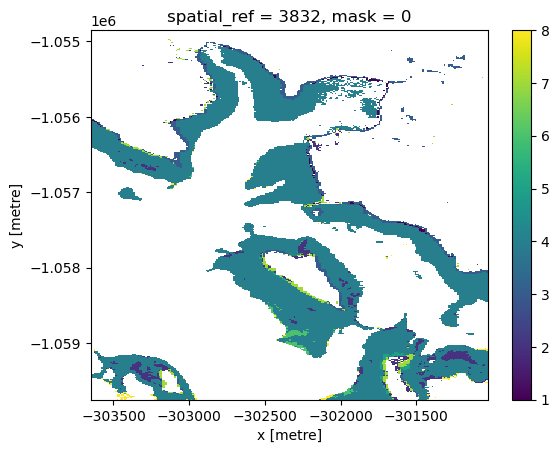

In [33]:
predicted.plot()

In [34]:
predicted

<xarray.DataArray (y: 490, x: 262)> Size: 514kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    mask         int64 8B 0

In [35]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

seagrass_value = 4
values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

# predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

In [36]:
# seagrass_da = predicted.where(predicted == seagrass_value)
# bounds = values_list + [__builtins__.max(values_list) + 1]
# norm = colors.BoundaryNorm(bounds, c_map.N)

# plt.figure(figsize=(8, 8))
# seagrass_da.plot.imshow(
#     cmap=c_map,
#     norm=norm,
#     add_colorbar=False
# )

In [37]:
seagrass_extent = output(predicted, seagrass_value)

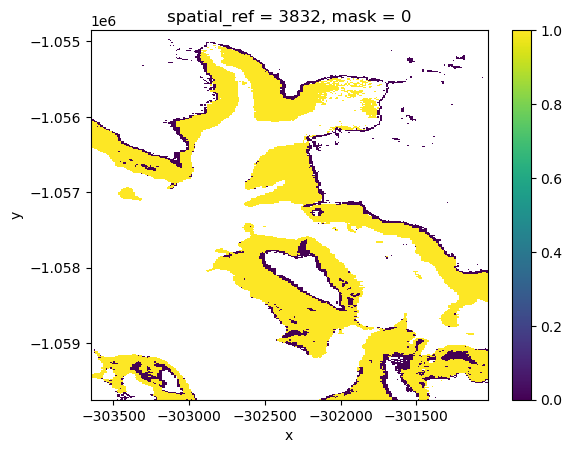

In [38]:
seagrass_extent.plot()

In [39]:
# probabilities = model.predict_proba(stacked_arrays)

In [40]:
masked_scaled

<xarray.Dataset> Size: 30MB
Dimensions:      (y: 490, x: 262)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir          (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    blue         (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    green        (y, x) float64 1MB nan nan nan nan nan ... nan nan nan nan nan
    emad         (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    smad         (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    ...           ...
    homogeneity  (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    energy       (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    ASM          (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    correlation  (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    mean         (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan
    entropy      (y, x) float32 514kB nan nan nan nan nan ... nan nan nan nan

In [42]:
probability_output = probability(
    masked_scaled,
    model, 
    ['nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2', 'rededge3', 'mndwi', 'ndti', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'contrast', 'homogeneity', 'energy', 'ASM', 'correlation', 'mean', 'entropy'],
    seagrass_value,
)

Generating probability raster for class ID: 4
DEBUG: 'bands' list provided to function: ['nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2', 'rededge3', 'mndwi', 'ndti', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'contrast', 'homogeneity', 'energy', 'ASM', 'correlation', 'mean', 'entropy']
DEBUG: Length of 'bands' list provided: 34
DEBUG: Columns of features_df (after dropping coordinates, before NaNs/no_data): ['nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2', 'rededge3', 'mndwi', 'ndti', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'contrast', 'homogeneity', 'energy', 'ASM', 'correlation', 'mean', 'entropy']
DEBUG: Number of columns in features_df (after dropping coordinates): 34
DEBUG: Shape of features_for_prediction_np (after processing): (30185, 34)
DEBUG: Model e

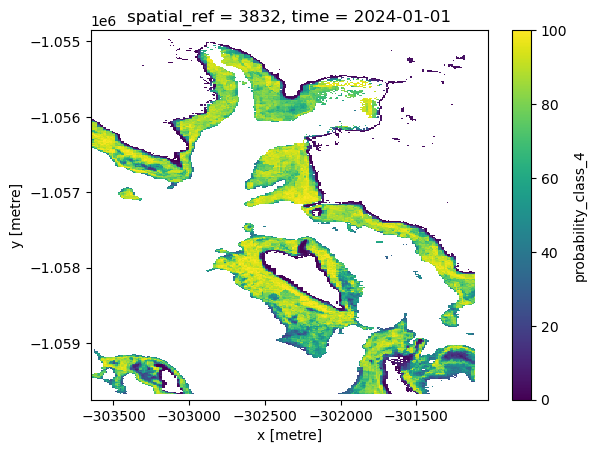

In [43]:
probability_output.plot()

In [ ]:
seagrass_extent.odc.write_cog(f"predictions/{version}-prediction.tif", crs="EPSG:3832", overwrite=True)

In [ ]:
predicted